In [1]:
# To find out where the pyspark
import findspark
findspark.init()

In [2]:
# Creating Spark Context
from pyspark import SparkContext, SparkConf

conf = (SparkConf()
         .setMaster("local")
         .setAppName("pbl-2")
         .set("spark.executor.cores", "1")) # 코어 수

sc = SparkContext(conf = conf)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

#### 데이터셋 생성 및 변수 정의

(source, destination set) 맵핑

In [4]:
data = sc.textFile("test_dataset.txt").flatMap(lambda file: file.split('\n')).map(lambda line: line.split(' '))\
            .map(lambda line: (int(line[0]), [int(i) for i in line[1:]]))
N = data.count()

block = [16, 8, 4, 2, 1]
maxIter = 20
execution_time = []

#### 블록 단위로 Link Structure 구축

(block id, (source, destination set)) 맵핑

In [5]:
def make_link_set(dest_set, block_cnt, block_size):
    source = dest_set[0]
    block_based_dest_set = [(source, []) for i in range(block_cnt)]
    
    for dest in dest_set[1]:
        block_based_dest_set[dest // block_size][1].append(dest)
        
    for i in range(block_cnt):
        if len(block_based_dest_set[i][1]) != 0: 
            yield (i,block_based_dest_set[i])

#### 블록 별 Page Rank 계산

In [6]:
def pr_map(block_data, block_size, N):
    block_id, link_sets = block_data
    new_sr = np.zeros(block_size) + 1.5/N
    
    for link_set in link_sets:
        source, dest_set = link_set
        val = pr.value[source] / len(dest_set)

        for dest in dest_set:
            new_sr[dest // block_size] += val
        
    yield new_sr.tolist()

#### Block Based Page Rank Calculation

1. destination node id의 범위에 따라 destination set을 블록 개수만큼 나누어 번호를 붙인다. (block_id, (source, destination set))
  
  
2. 같은 블록 id를 가지는 (source, destination set)을 groupByKey로 모아 블록을 만들어 준다.
  
  
3. maxIter 만큼 반복하며 블록 별로 PageRank 값을 계산한다.
  
  
4. 블록 별로 계산한 PageRank 리스트를 reduce로 합친다.

In [7]:
for block_cnt in block: # block의 개수를 바꿔가며 실행
    start = time.time()
    
    pr = sc.broadcast([ 1. / float(N) for _ in range(N) ]) 
    block_size = (N // block_cnt) if N % block_cnt != 0 else (N // block_cnt)+1
    
    # source별 destination set을 블록 구간에 따라 분리함
    block_based_set = data.flatMap(lambda s: make_link_set(s, block_cnt, block_size)).groupByKey()
    
    for _ in range(maxIter):
        itr = block_based_set.flatMap(lambda b: pr_map(b, block_size, N)).reduce(lambda x,y : x+y)
        pr = sc.broadcast(itr)
    
    end = time.time()
    execution_time.append(end-start)

    print("the number of blocks: {}".format(block_cnt))
    print("duration: {}".format(end-start))
    print()

the number of blocks: 16
duration: 14.0278959274292

the number of blocks: 8
duration: 10.228794813156128

the number of blocks: 4
duration: 10.281517744064331

the number of blocks: 2
duration: 9.360647916793823

the number of blocks: 1
duration: 8.861914873123169



#### 그래프

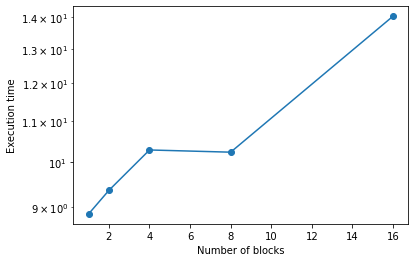

In [8]:
plt.plot(block, execution_time, marker = 'o')

plt.xlabel("Number of blocks")
plt.ylabel("Execution time")

plt.yscale('log')
plt.show()